In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sfma.api import SFMAModel

## Make Simulations

In [2]:
np.random.seed(1)

In [3]:
n = 100

In [4]:
intercept = 1.5
slope = 5

x_domain = [0, 10]

ineff = 0.4

sample_size_1 = [100, 0.7]
sample_size_2 = [100, 0.3]

In [5]:
def frontier(x):
    return np.log(intercept + slope * x)

In [6]:
def simulate():
    x = np.random.uniform(low=x_domain[0], high=x_domain[1], size=n)
    sample_sizes_1 = np.random.negative_binomial(
        n=sample_size_1[0], p=sample_size_1[1], size=int(n / 2)
    )
    sample_sizes_2 = np.random.negative_binomial(
        n=sample_size_2[0], p=sample_size_2[1], size=int(n / 2)
    )
    sample_sizes = np.append(sample_sizes_1, sample_sizes_2)
    
    the_frontier = frontier(x)
    inefficiency = np.random.exponential(ineff, size=n)
    means = the_frontier - inefficiency
    samples = [np.random.normal(m, scale=4, size=s) for m, s in zip(means, sample_sizes)]
    est_means = np.array([np.mean(s) for s in samples])
    est_sterr = np.array([np.sqrt(np.sum(sum((s - np.mean(s))**2)) / ((len(s) - 1)))/np.sqrt(len(s)) for s in samples])
    df = pd.DataFrame({
        'output': est_means,
        'se': est_sterr,
        'input': x,
        'ones': np.ones(len(x)),
        'frontier': the_frontier,
        'truth': means,
        'sample_size': sample_sizes
    })
    return df

In [7]:
sim = simulate()

In [8]:
the_frontier = sim['frontier']
linspace = np.linspace(x_domain[0], x_domain[1])
front = frontier(linspace)

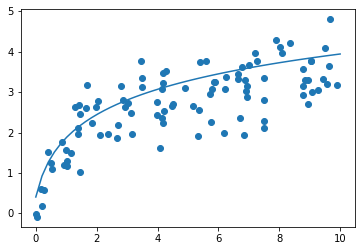

In [9]:
plt.plot(linspace, front, linestyle='solid')
plt.scatter(sim.input, sim.output)

<ErrorbarContainer object of 3 artists>

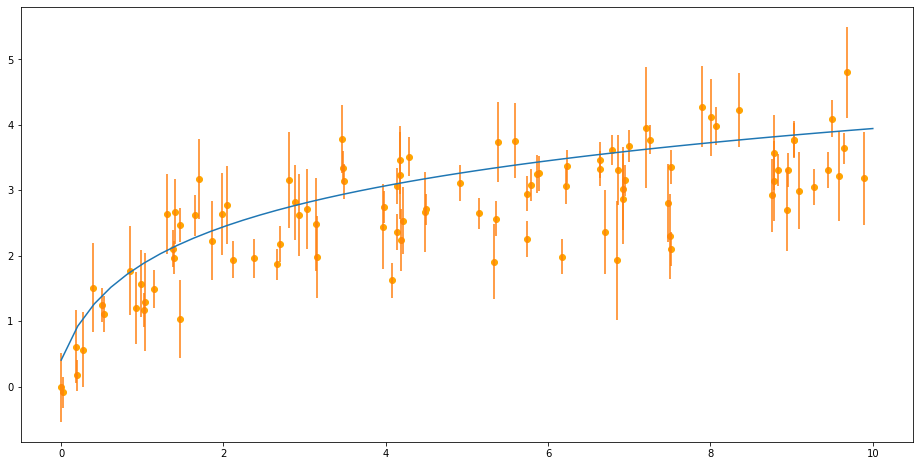

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(linspace, front, linestyle='solid')
ax.scatter(sim.input, sim.output, color='orange')
ax.errorbar(sim.input, sim.output, yerr=sim.se, linestyle='None')

In [11]:
model = SFMAModel(
    df=sim,
    col_output='output',
    col_se='se',
    col_input='input',
)
no_se_model = SFMAModel(
    df=sim,
    col_output='output',
    col_se='ones',
    col_input='input'
)
lin_tails = SFMAModel(
    df=sim,
    col_output='output',
    col_se='se',
    col_input='input',
    r_linear=True
)

In [12]:
model.fit()
no_se_model.fit()
lin_tails.fit()

/Users/marlena/repos/SFMA/src/sfma/models/marginal.py:32: RuntimeWarning: divide by zero encountered in log
  return np.mean(r**2 / (2 * V) + 0.5 * np.log(V) - np.log(Phi))
/opt/miniconda3/envs/sfma/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


In [13]:
sim['base_predictions'] = model.predict()
sim['no_se_predictions'] = no_se_model.predict()
sim['linear_tail_predictions'] = lin_tails.predict()
sim.sort_values('input', inplace=True)

In [14]:
sim

,output,se,input,ones,frontier,truth,sample_size,base_predictions,no_se_predictions,linear_tail_predictions
2,-0.009909,0.529911,0.001144,1.0,0.409270,-0.036297,49,0.344069,0.923142,0.342952
98,-0.086879,0.239538,0.028703,1.0,0.496838,-0.007985,272,0.406790,0.947200,0.405722
38,0.613305,0.562513,0.182883,1.0,0.881457,0.827490,54,0.739528,1.077554,0.738666
50,0.173679,0.237877,0.193670,1.0,0.903549,0.536077,254,0.761677,1.086411,0.760826
14,0.567568,0.573602,0.273876,1.0,1.054096,0.906457,36,0.921858,1.151234,0.921067
...,...,...,...,...,...,...,...,...,...,...
91,4.091218,0.280831,9.494893,1.0,3.891299,3.813598,221,3.948512,2.231253,4.020130
32,3.210637,0.680041,9.578895,1.0,3.899839,3.754579,43,3.939896,2.108609,4.033537
87,3.642864,0.237240,9.648400,1.0,3.906850,3.586479,259,3.931307,2.003770,4.044630
21,4.800815,0.696118,9.682616,1.0,3.910283,3.720947,45,3.926580,1.951034,4.050090


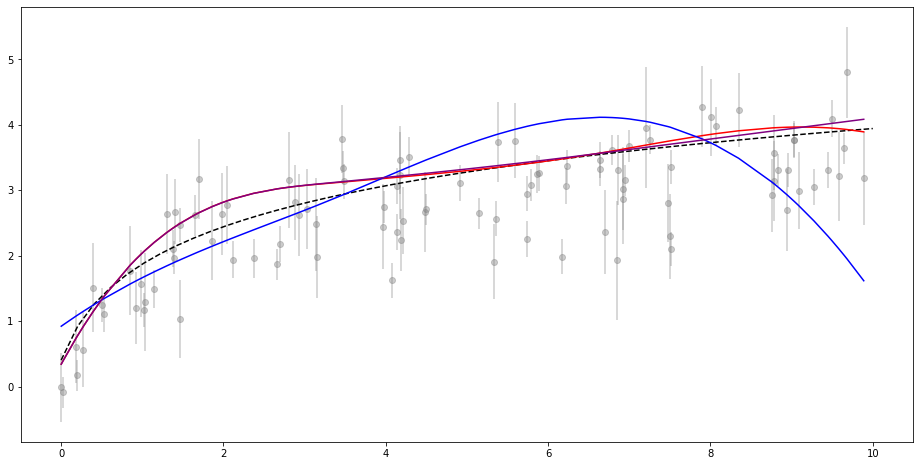

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(16, 8))
axes.plot(linspace, front, linestyle='dashed', color='black')
axes.scatter(sim.input, sim.output, color='grey', alpha=0.4)
axes.errorbar(sim.input, sim.output, yerr=sim.se, linestyle='None', color='grey', alpha=0.4)
axes.plot(sim.input, sim.base_predictions, color='red')
axes.plot(sim.input, sim.no_se_predictions, color='blue')
axes.plot(sim.input, sim.linear_tail_predictions, color='purple')

## Simulations

In [19]:
num_simulations = 10

In [21]:
sim_dfs = []
for i in range(num_simulations):
    sim_i = simulate()
    model = SFMAModel(
        df=sim_i,
        col_output='output',
        col_se='se',
        col_input='input',
    )
    no_se_model = SFMAModel(
        df=sim_i,
        col_output='output',
        col_se='ones',
        col_input='input'
    )
    lin_tails = SFMAModel(
        df=sim_i,
        col_output='output',
        col_se='se',
        col_input='input',
        r_linear=True
    )
    model.fit()
    no_se_model.fit()
    lin_tails.fit()
    sim_i['base_predictions'] = model.predict()
    sim_i['no_se_predictions'] = no_se_model.predict()
    sim_i['linear_tail_predictions'] = lin_tails.predict()
    sim_i.sort_values('input', inplace=True)
    sim_dfs.append(sim_i)

/Users/marlena/repos/SFMA/src/sfma/models/marginal.py:32: RuntimeWarning: divide by zero encountered in log
  return np.mean(r**2 / (2 * V) + 0.5 * np.log(V) - np.log(Phi))
/opt/miniconda3/envs/sfma/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/marlena/repos/SFMA/src/sfma/models/marginal.py:30: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(eta) * r / np.sqrt(2 * V * (gamma + data.sigma2))


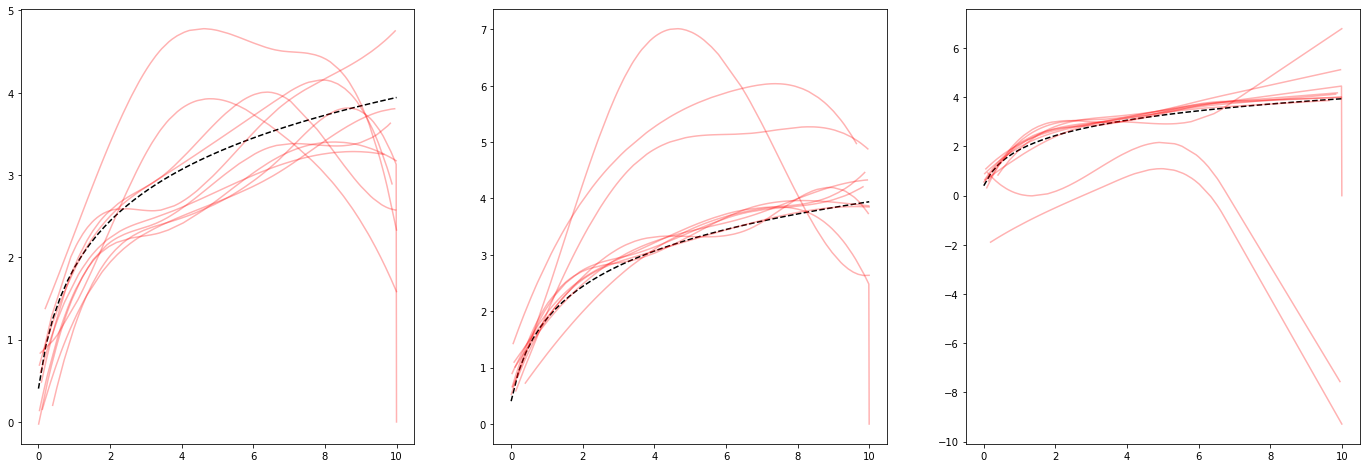

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
for i, kind in enumerate(['no_se_predictions',
                         'base_predictions',
                         'linear_tail_predictions']):
    axes[i].plot(linspace, front, linestyle='dashed', color='black')
    for df in sim_dfs:
        axes[i].plot(df.input, df[kind], color='red', alpha=0.3)